In [1]:
import os
import numpy as np
from scipy.optimize import linear_sum_assignment

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode = False, precision = 4)

In [2]:
# Hyperparameters
class HParams:
    def __init__(self):
        
        self.num_states = 2
        self.num_signals = 2
        
        # Minibatch size
        self.batch_size = 2**15
        self.num_menus = 1000

        # Opt params
        self.lr = 1e-3        
        self.pi_temp = 0.2
        self.u_temp = 0.005
                
        # Miscellaneous
        self.seed = 0
                  
        self.max_iter = 20000 
        self.print_iter = 1000
        
        self.device = "cuda"
        
        self.tst_num_batches = 1000
                
# Initialize config
cfg = HParams()
np.random.seed(cfg.seed)
device = "cuda"

# Utils
def torch_var(x): return torch.tensor(x, device = cfg.device)
def numpy_var(x): return x.detach().cpu().numpy()

In [3]:
class RochetNet(torch.nn.Module):
    def __init__(self, cfg):
        super(RochetNet, self).__init__()
        self.num_menus = cfg.num_menus
        self.num_states = cfg.num_states
        self.num_signals = cfg.num_signals
        self.device = cfg.device
        
        self.pi_temp_inv = torch.tensor(1.0/cfg.pi_temp).to(device)
        self.u_temp_inv = torch.tensor(1.0/cfg.u_temp).to(device)
        
        #  Experiments and payments
        self.pi = torch.empty((self.num_menus, self.num_states, self.num_signals), device = self.device, requires_grad = True)
        self.pay = torch.empty((self.num_menus), device = self.device, requires_grad = True)
        
        # For IR constraints
        self.pi_0 = torch.empty(1, self.num_states, self.num_signals).to(self.device)
        self.pay_0 = torch.empty(1).to(self.device)
        
        # Initialization
        self.reset_parameters()
        
        
    def reset_parameters(self):
        
        # Initialize pi and pay
        nn.init.uniform_(self.pi.data, -1.0, 1.0)
        nn.init.zeros_(self.pay.data)
                
        # Initialize IR menu
        nn.init.ones_(self.pi_0.data)
        nn.init.zeros_(self.pay_0.data)
        self.make_responsive()
        
    def make_responsive(self):
        
        pi = numpy_var(self.pi)
        for i in range(len(pi)):
            _, col_ind = linear_sum_assignment(pi[i], True)
            pi[i] = pi[i][:, col_ind]
        self.pi = torch.tensor(pi, device = self.device, requires_grad = True)
        
    def delete_duplicates(self):
        
        pi_menu, pay_menu = self.get_menu()
        pi_menu = numpy_var(pi_menu[:-1])
        pay_menu = numpy_var(pay_menu[:-1])

        # Sort by prices
        pi_menu = np.round(pi_menu, 4)
        sort_idx = np.argsort(pay_menu)
        pi_menu, pay_menu = pi_menu[sort_idx], pay_menu[sort_idx]

        # Select unique
        _, unique_idx = np.unique(pi_menu, axis = 0, return_index = True)
        pi, pay = numpy_var(self.pi), numpy_var(self.pay)
        pi, pay = pi[unique_idx], pay[unique_idx]
        prev_num_menus = self.num_menus
        self.num_menus = len(unique_idx)
        
        self.pi = torch.tensor(pi, device = self.device, requires_grad = True)
        self.pay = torch.tensor(pay, device = self.device, requires_grad = True)
        print("Updated num_menus from %d --->: %d"%(prev_num_menus, self.pi.shape[0]))
        
    def get_menu(self):
        pi_menu = F.softmax(self.pi_temp_inv * torch.cat([self.pi, self.pi_0]), dim = -1)
        pay_menu = torch.cat([self.pay, self.pay_0])
        return pi_menu, pay_menu
    
    def forward(self, theta):
        pi_menu, pay_menu = self.get_menu()
        utility = torch.max(theta[:, None, :, None] * pi_menu, axis = -2)[0].sum(axis = -1) - pay_menu[None, :]
        menu_idx = F.softmax( self.u_temp_inv * utility, dim = -1)
        rev = menu_idx * pay_menu
        return rev.sum(axis = -1)
    
    def compute_mechanism(self, theta):
        pi_menu, pay_menu = self.get_menu()
        utility = torch.max(theta[:, None, :, None] * pi_menu, axis = -2)[0].sum(axis = -1) - pay_menu[None, :]
        menu_idx = torch.argmax(utility, axis = -1)
        return pi_menu[menu_idx], pay_menu[menu_idx]
        
# Take care of u(theta) = \max {theta}

In [4]:
def sample_batch(batch_size, a, b, l = 0.5):
    T1 = np.random.dirichlet([a, b], batch_size)
    T2 = np.random.dirichlet([60, 30], batch_size)
    mask = np.random.binomial(1, 1-l, size = (batch_size,1))
    return mask * T1 + (1 - mask) * T2

In [5]:
'''
The following code below is for numerical approximation for finding distributions
with the same mode as a given number and the same peak (probability density at mode) 
as beta(8,30).
'''
import scipy.special

In [6]:
def calculate_peak(a,b):
    mode = (a-1)/(a+b-2)
    # Output probability density at the mode
    return (1/scipy.special.beta(a,b))*np.power(mode,a-1)*np.power((1-mode),b-1)

In [7]:
def find_b(mode, a):
    return (2*mode-1+a*(1-mode))/mode

In [8]:
def approx(mode):
    start = 10
    while True:
        start += 0.0001
        b = find_b(mode, start)
        peak = calculate_peak(start,b)
        if abs(peak - 6.139114141545872)<0.0001:
            return start, b

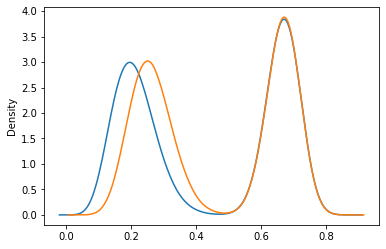

In [9]:
# Example illustration
import seaborn as sns
n_samples = 1000000
data = sample_batch(n_samples, 8, 30)[:,0]
sns.kdeplot(data)
data2 = sample_batch(n_samples, 11.781499999995848, 33.34449999998755)[:,0]
sns.kdeplot(data2)

In [10]:
import time


def train(a, b, l=0.5):
    tic = time.time()
    net = RochetNet(cfg).to(device)
    opt = torch.optim.RMSprop([net.pi, net.pay], lr=1e-3)
    it = 1

    while it <= cfg.max_iter:

        opt.zero_grad()
        theta = torch_var(sample_batch(cfg.batch_size, a, b, l))
        rev = net(theta).mean()
        loss = -rev
        loss.backward()
        opt.step()

        if it % cfg.print_iter == 0:
            print(
                "[Iter: %d], [Time Elapsed: %.2fs], [Revenue: %.4f]"
                % (it, time.time() - tic, rev.item())
            )

        if it % 1000 == 0:

            # Delete duplicates
            net.delete_duplicates()

            # Delete unused menus
            used_menus = torch_var(np.zeros((net.pi.shape[0] + 1)))
            with torch.no_grad():
                pi_menu, pay_menu = net.get_menu()
                for _ in range(cfg.tst_num_batches):
                    theta = torch_var(sample_batch(cfg.batch_size, a, b, l))
                    utility = (
                        torch.max(theta[:, None, :, None] * pi_menu, axis=-2)[0].sum(
                            axis=-1
                        )
                        - pay_menu[None, :]
                    )
                    menu_idx = F.softmax(net.u_temp_inv * utility, dim=-1)
                    menu_idx.data[menu_idx.data < 0.001] = 0.0
                    used_menus += menu_idx.sum(axis=0)

                used_menus = used_menus / (cfg.tst_num_batches * cfg.batch_size)

                net.pi = net.pi[used_menus[:-1] > 1e-3]
                net.pay = net.pay[used_menus[:-1] > 1e-3]

            net.pi.requires_grad = True
            net.pay.requires_grad = True
            net.num_menus = net.pi.shape[0]
            print("Deleted unused menus. Current: %d" % (net.num_menus))

            opt = torch.optim.RMSprop([net.pi, net.pay], lr=1e-3)

        it += 1
    with torch.no_grad():
        test_revenue = 0.0
        for _ in range(cfg.tst_num_batches):
            theta = torch_var(sample_batch(cfg.batch_size, a, b, l))
            test_revenue += net.compute_mechanism(theta)[1].mean().item()
        test_revenue = test_revenue / cfg.tst_num_batches
        print("[Test Revenue: %.4f]" % (test_revenue))

    print(
        f"The RochetNet output for mixture of Beta({a}, {b}) and Beta(60, 30) with frequency {l} gives the allocation and respective payment: "
    )
    pi_menu, pay_menu = net.get_menu()
    print(
        "Experiments: ",
        pi_menu.detach().cpu().numpy(),
        "Prices: ",
        pay_menu.detach().cpu().numpy(),
    )
    return net


In [11]:
'''
Below we provide the datapoints used for our experiments
'''

modes = [
    (0.25, (11.781499999986526, 33.34449999995958)),
    (0.23, (10.364999999996819, 32.352391304337175)),
    (0.21, (9.00749999998833, 31.12345238090848)),
    (7/36, (8, 30)),
    (0.17, (6.515099999994138, 27.926664705853728)),
    (0.15, (5.402799999996731, 25.949199999981474)),
    (0.14, (4.885099999997937, 24.865614285701614)),
    (0.13, (4.39489999999908, 23.719715384609227)),
    (0.11, (3.502500000000216, 21.247500000001754)),
    (0.09, (2.736400000001554, 18.556933333349047))
]

In [ ]:
def grid_search(modes):
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    for mode, (alpha, beta) in modes:
        precision = abs(mode-0.5)
        print(f"--- Beginning training loop for mode at {mode} and precision of {precision}, frequency = 0.5 ----")
        net = train(alpha, beta, 0.5)
        file_name = f"mode_{mode}_precision_{precision}_freq_0.5.pt"
        torch.save(net, os.path.join("experiments", file_name))

grid_search(modes)

In [22]:
# Low type (mode of Beta(a,b)) don't necessarily choose the partially informative experiment
# Find out the menu that the mode uses
for i in range(len(modes)):  
    mode, (alpha, beta) = modes[i]
    precision = abs(mode - 0.5)
    file_name = f"mode_{mode}_precision_{precision}_freq_0.5.pt"
    net = torch.load(os.path.join("experiments", file_name))
    net.eval()  # Set the network to evaluation mode
    pi, pay = net.compute_mechanism(torch_var(np.array([[mode,1-mode]])))
    print(f"In experiment with mode of Beta(a,b) at {mode}, low type uses experiment", pi)

In experiment with mode of Beta(a,b) at 0.25, low type uses experiment tensor([[[    1.0000,     0.0000],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with mode of Beta(a,b) at 0.23, low type uses experiment tensor([[[    0.8459,     0.1541],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with mode of Beta(a,b) at 0.21, low type uses experiment tensor([[[    0.8014,     0.1986],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with mode of Beta(a,b) at 0.19444444444444445, low type uses experiment tensor([[[    0.7709,     0.2291],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with mode of Beta(a,b) at 0.17, low type uses experiment tensor([[[    0.7277,     0.2723],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with mode of Beta(a,b) at 0.15, low type 

In [ ]:
def grid_search_lambdas(modes):
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    l_values = [round(x * 0.05, 2) for x in range(21)]  # Generate l values from 0.00 to 1.00 with a step size of 0.05

    alpha_fixed = 8
    beta_fixed = 30
    for l in l_values:
        print(f"-- Beginning training loop for frequency = {l} ---")
        net = train(alpha_fixed, beta_fixed, l)
        file_name = f"freq_{l}.pt"
        torch.save(net, os.path.join("experiments", file_name))

grid_search_lambdas(modes)

In [23]:
# load all checkpoints
l_values = [round(x * 0.05, 2) for x in range(21)]  # Generate l values from 0.00 to 1.00 with a step size of 0.05
for l in l_values:
    file_name = f"freq_{l}.pt"
    net = torch.load(os.path.join("experiments",file_name))
    net.eval()  # Set the network to evaluation mode
    pi, pay = net.compute_mechanism(torch_var(np.array([[7/36,1-7/36]])))
    print(f"In experiment with frequency {l}, low type uses experiment", pi)

In experiment with frequency 0.0, low type uses experiment tensor([[[    1.0000,     0.0000],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with frequency 0.05, low type uses experiment tensor([[[    1.0000,     0.0000],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with frequency 0.1, low type uses experiment tensor([[[    1.0000,     0.0000],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with frequency 0.15, low type uses experiment tensor([[[    1.0000,     0.0000],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with frequency 0.2, low type uses experiment tensor([[[    1.0000,     0.0000],
         [    0.0000,     1.0000]]], device='cuda:0', grad_fn=<IndexBackward0>)
In experiment with frequency 0.25, low type uses experiment tensor([[[    1.0000,     0.0000],
         [    0.0000,     1.0000]